<center><img src="images/header.png"></center>

<h1><center>Алгоритмы интеллектуальной обработки больших объемов данных</center></h1>
<hr>
<h2><center>Деревья решений, случайные леса (практика)</center></h2>

**Срок сдачи:** 3 апреля 2017, 06:00 <br> 
**Штраф за опоздание:** -2 балла после 06:00 3 апреля, -4 балла после 06:00 10 апреля, -6 баллов после 06:00 17 апреля

При отправлении ДЗ указывайте фамилию в названии файла<br>

Не забудте создать задание в Slack через /todo.

Используйте данный Ipython Notebook при оформлении домашнего задания.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import cross_val_score, train_test_split

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Практика

### Качество вина (10 баллов)

Давайте все-таки разберемся с [вином](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv)!


#### Задание (1 балл)
* Загрузите данные, выполните преобразование целевой переменной: 
    * quality > 5 -> 1
    * quality <= 5 -> 0
* Разделите выборку на обучающую и контрольную в пропорции 80/20

In [2]:
!pip install tqdm

  Using cached tqdm-4.11.2-py2.py3-none-any.whl


In [3]:
from tqdm import tqdm_notebook

In [4]:
df_wine = pd.read_csv('winequality-red.csv', sep=';')
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [13]:
def build_y(x):
    return 1*(x>5)

In [16]:
x = np.array(df_wine)
y = np.copy(x[:,-1])
x = x[:,:11]
y = build_y(y)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=0)

#### Задание (2 балла)

Сфокусируемся на одном гиперпараметре деревьев решений - максимальной глубине.

Подберите наилучшую глубину `d` дерева с помошью 
* Усредненной оценки качества roc-auc на кросс-валидации при различных `d`
* Валидационных кривых

In [18]:
from sklearn.tree import DecisionTreeClassifier

try:
    from sklearn.model_selection import cross_val_score
except ImportError:
    from sklearn.cross_validation import cross_val_score

try:
    from sklearn.model_selection import validation_curve
except ImportError:
    from sklearn.learning_curve import validation_curve

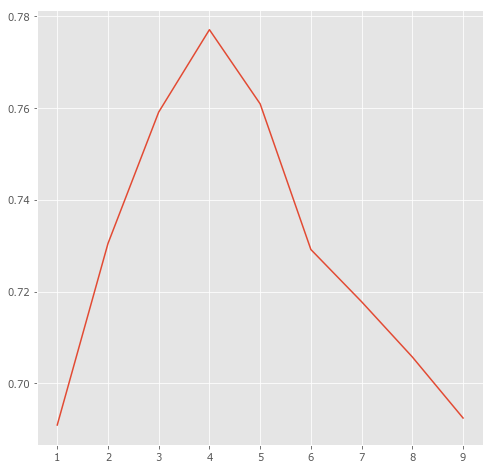

In [21]:
cv_score = []
for depth in xrange(1,10):
    tree = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=123)
    cv_score.append(cross_val_score(tree, x, y,scoring='roc_auc', cv=10).mean())

plt.figure(figsize=(8, 8))
plt.plot(np.arange(1,10),cv_score)
plt.show()
    

 Оптимальная глубина 4

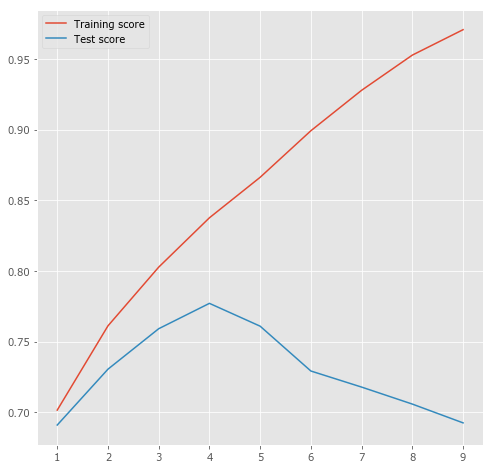

In [26]:
depth = np.arange(1,10)
tree = DecisionTreeClassifier(criterion='entropy', random_state=123)
train_scores, test_scores = validation_curve(tree, 
    x, y, param_name="max_depth", param_range=depth, cv=10, scoring="roc_auc")

plt.figure(figsize=(8, 8))
plt.plot(np.arange(1,10), train_scores.mean(axis=1), label="Training score")
plt.plot(np.arange(1,10), test_scores.mean(axis=1), label="Test score")
plt.legend(loc="best")
plt.show()

 Как и в предыдущем случает оптимальной глубиной получается 4

#### Задание (1 балл)

Отсортируйте признаки по важности. Вектор с важностью признаков можно получить с помощью `model.feature_importances_`

In [47]:
df = pd.DataFrame(tree.feature_importances_, index=df_wine.columns[:-1].values, columns=['Importance'])
df.sort_values(by=['Importance'], ascending=False)

,Importance
alcohol,0.302982
sulphates,0.135140
total sulfur dioxide,0.117872
volatile acidity,0.117384
fixed acidity,0.063594
citric acid,0.058582
pH,0.049523
chlorides,0.047113
residual sugar,0.041453
density,0.036916


#### Задание (2 балла)
* Получите предсказания на тестовой выборке
* Постройте ROC кривые для обучающей и тестовой выборок
* Посчитайте остальные меры качества классификации при пороге в `0.5`

In [52]:
depth = 4
tree = DecisionTreeClassifier(max_depth=depth)
tree.fit(x_train,y_train)

y_hat_train = tree.predict_proba(x_train)
y_hat_test = tree.predict_proba(x_test)

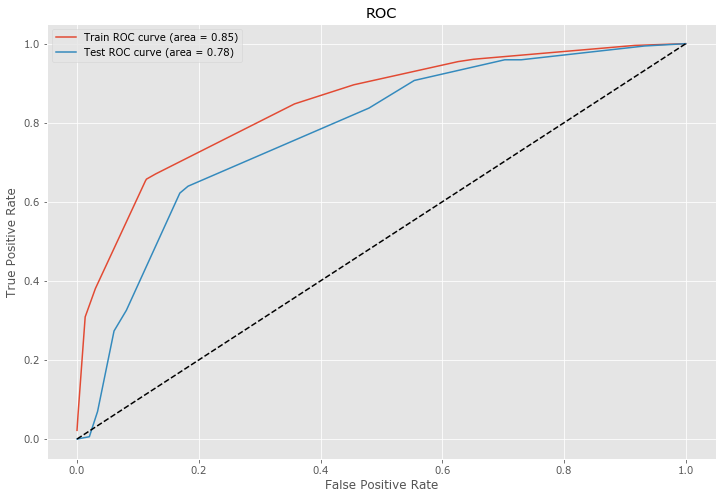

In [59]:
from sklearn.metrics import roc_curve, auc
fpr_train, tpr_train, _ = roc_curve(y_train, y_hat_train[:, 1])
roc_auc_train = auc(fpr_train, tpr_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_hat_test[:, 1])
roc_auc_test = auc(fpr_test, tpr_test)

plt.plot(fpr_train, tpr_train, label='Train ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, label='Test ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], 'k--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="best")

In [65]:
def y_pred(y, threshold):
    return 1*(y >= threshold) 

In [71]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

y_hat = y_pred(y_hat_test[:,1],0.5)
print 'accuracy_score: ', accuracy_score(y_test, y_hat)
print 'f1_score: ', f1_score(y_test, y_hat)
print 'precision_score: ', precision_score(y_test, y_hat)
print 'recall_score: ', recall_score(y_test, y_hat)
print 'roc_auc_score: ', roc_auc_score(y_test, y_hat)


accuracy_score:  0.721875
f1_score:  0.711974110032
precision_score:  0.802919708029
recall_score:  0.639534883721
roc_auc_score:  0.728551225644


#### Задание (1 балл)
Перейдем к модели случайного леса. Зафиксируем некоторую глубину дерева (можно звять оптимальное с предыдущих заданий).

Сравните качество работы 
* Простого дерева решений
* Бэггинга над 10,20,...,100 деревьями решений
* Случайного леса с 10,20,...,100 деревьями решений

Получите график, у которого по оси X откладывается количество деревьев, а по оси Y - качество классификации.

In [72]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

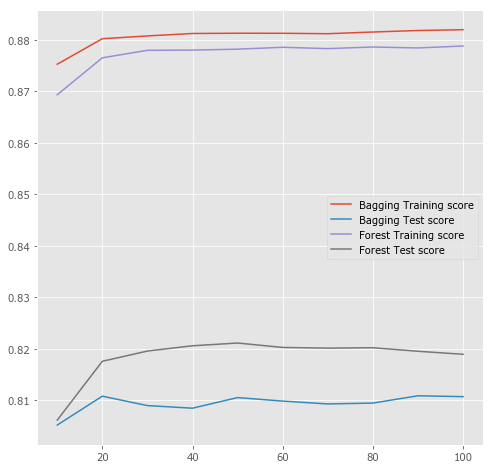

In [73]:
depth = 4
tree_numb = np.arange(10,101,10)
tree = DecisionTreeClassifier(max_depth=depth, random_state=123)
bagging = BaggingClassifier(base_estimator=tree, random_state=123)
random_forest = RandomForestClassifier(max_depth=depth, random_state=123)

bagging_train_scores, bagging_test_scores = validation_curve(bagging, 
    x, y, param_name="n_estimators", param_range=tree_numb, cv=10, scoring="roc_auc")
forest_train_scores, forest_test_scores = validation_curve(random_forest, 
    x, y, param_name="n_estimators", param_range=tree_numb, cv=10, scoring="roc_auc")

plt.figure(figsize=(8, 8))
plt.plot(tree_numb, bagging_train_scores.mean(axis=1), label="Bagging Training score")
plt.plot(tree_numb, bagging_test_scores.mean(axis=1), label="Bagging Test score")
plt.plot(tree_numb, forest_train_scores.mean(axis=1), label="Forest Training score")
plt.plot(tree_numb, forest_test_scores.mean(axis=1), label="Forest Test score")
plt.legend(loc="best")
plt.show()

Для простого деревы мы получали тестовый auc 0.78. Видим, что случайный лес в данном случае точнее. 

####  Задание (3 балла)
* С помощью `GridSearchCV` или `RandomSearchCV` подберите наиболее оптимальные параметры для случайного леса.
* Для этих параметров сравните средние результаты по кросс-валидации и качество на контрольной выборке

In [78]:
from sklearn.model_selection import GridSearchCV

In [77]:
from sklearn.model_selection import RandomizedSearchCV

In [84]:
depth = np.arange(1,30)
tree_numb = np.arange(10,101,10)
random_forest = RandomForestClassifier(random_state=123)

param_dist = {"max_depth": depth,
              "n_estimators": tree_numb,
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

random_search = RandomizedSearchCV(random_forest, param_distributions=param_dist, n_iter=20, scoring='roc_auc', cv=10)
random_search.fit(x_train, y_train)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=123,
            verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]), 'bootstrap': [True, False], 'criterion': ['gini', 'entropy'], 'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=0)

In [85]:
print random_search.best_params_

{'n_estimators': 90, 'bootstrap': False, 'criterion': 'entropy', 'max_depth': 22}


In [86]:
best = random_search.best_estimator_
y_hat = best.predict_proba(x_test)[:,1]
print roc_auc_score(y_test, y_hat)
print cross_val_score(best, x, y,scoring='roc_auc', cv=10).mean()

0.911297925833
0.793702788972
